In [1]:
import json
import argparse

# 数据可视化控制参数
PLOT_FEATURES = False  # 设置为False可以跳过特征绘制，加快数据加载速度

# 命令行参数解析
parser = argparse.ArgumentParser()
parser.add_argument('--train_xj', type=str, default=None, help='训练轴承列表, 逗号分隔')
parser.add_argument('--test_xj', type=str, default=None, help='测试轴承列表, 逗号分隔')
parser.add_argument('--context_xj', type=str, default=None, help='上下文轴承列表, 逗号分隔')
parser.add_argument('--validation_xj', type=str, default=None, help='验证轴承列表, 逗号分隔')
parser.add_argument('--plot', action='store_true', help='是否绘制特征图')
args, unknown = parser.parse_known_args()

# 如果有命令行参数，则覆盖默认设置
if hasattr(args, 'plot') and args.plot:
    PLOT_FEATURES = args.plot

with open('../../config/fbtcn_config_jupyter_bak.json', 'r') as f:
    config = json.load(f)

print(f"🎨 特征可视化: {'开启' if PLOT_FEATURES else '关闭'}")

# 解析命令行参数，优先级高于config
if args.train_xj is not None:
    TRAIN_xj = [x.strip() for x in args.train_xj.split(',') if x.strip()]
else:
    TRAIN_xj = config['train_bearings']
if args.test_xj is not None:
    TEST_xj = [x.strip() for x in args.test_xj.split(',') if x.strip()]
else:
    TEST_xj = config['test_bearings']
if args.context_xj is not None:
    CONTEXT_xj = [x.strip() for x in args.context_xj.split(',') if x.strip()]
else:
    CONTEXT_xj = config['context_bearings']
if args.validation_xj is not None:
    VALIDATION_xj = [x.strip() for x in args.validation_xj.split(',') if x.strip()]
else:
    VALIDATION_xj = config['validation_bearings']

batch_size = config['batch_size']
test_batch_size = config['test_batch_size']
window_size = config['window_size']
input_dim = config['input_dim']
output_dim = config['output_dim']
num_channels = config['num_channels']
kernel_size = config['kernel_size']
dropout = config['dropout']
epochs = config['epochs']
learn_rate = config['learn_rate']
init_kl_weight = config['kl_weight']
forward_pass = config['forward_pass']
seed = config['seed']
patience = config['patience']
opt = config['opt']
output_posterior_rho_init = config['output_posterior_rho_init']
conv_posterior_rho_init = config['conv_posterior_rho_init']
if patience == "inf":
    patience = epochs
else:
    patience = int(patience)
ci = config['ci']
attention_dim = config['attention_dim']
results_dir = config['results_dir']
scaler_dir = config['scaler_dir']


🎨 特征可视化: 关闭


In [2]:
# 加载数据
import torch
from joblib import dump, load
import torch.utils.data as Data
import numpy as np
import pandas as pd
import torch.nn as nn
import os
import matplotlib.pyplot as plt
import random

torch.autograd.set_detect_anomaly(True)

# ==================== 设置随机种子以确保结果可复现 ====================
def set_seed(seed_value, deterministic=True, benchmark=False):
    """
    设置所有随机数生成器的种子，确保结果可复现
    
    Args:
        seed_value: 随机种子值
        deterministic: 是否启用cuDNN确定性模式（True=完全可复现但较慢，False=较快但可能有微小差异）
        benchmark: 是否启用cuDNN benchmark模式（True=自动选择最快算法，False=使用固定算法）
    
    性能说明：
        - deterministic=True, benchmark=False: 完全可复现，但训练速度最慢（当前默认）
        - deterministic=False, benchmark=True: 训练速度最快，但结果可能有微小差异
        - deterministic=False, benchmark=False: 平衡模式，速度较快，结果基本可复现
    """
    # Python内置random模块
    random.seed(seed_value)
    
    # NumPy随机数生成器
    np.random.seed(seed_value)
    
    # PyTorch CPU随机数生成器
    torch.manual_seed(seed_value)
    
    # PyTorch CUDA随机数生成器（如果使用GPU）
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)  # 对所有GPU设置种子
        
        # cuDNN设置：在可复现性和性能之间权衡
        torch.backends.cudnn.deterministic = deterministic
        torch.backends.cudnn.benchmark = benchmark
        
        if deterministic:
            print(f"  ⚠️  cuDNN确定性模式已开启（可能降低训练速度）")
        if benchmark:
            print(f"  ⚡ cuDNN benchmark模式已开启（自动选择最快算法）")
    
    # 设置环境变量（用于某些底层库）
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    print(f"✓ 随机种子已设置为: {seed_value}")
    print(f"  - Python random: {seed_value}")
    print(f"  - NumPy: {seed_value}")
    print(f"  - PyTorch CPU: {seed_value}")
    if torch.cuda.is_available():
        print(f"  - PyTorch CUDA: {seed_value}")
        print(f"  - cuDNN确定性: {deterministic}, Benchmark: {benchmark}")


# 从配置文件读取性能模式（如果存在），否则使用默认值
use_deterministic = config.get('use_deterministic', True)  # 默认True，完全可复现
use_benchmark = config.get('use_benchmark', False)  # 默认False，不启用benchmark

set_seed(seed, deterministic=use_deterministic, benchmark=use_benchmark)

# 参数与配置
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"当前运行设备: {device}")

FPT_dict_xj = {'Bearing1_1': 76, 'Bearing1_2': 44, 'Bearing1_3': 60, 'Bearing1_4': 0, 'Bearing1_5': 39,
            'Bearing2_1': 455, 'Bearing2_2': 48, 'Bearing2_3': 327, 'Bearing2_4': 32, 'Bearing2_5': 141,
            'Bearing3_1': 2344, 'Bearing3_2': 0, 'Bearing3_3': 340, 'Bearing3_4': 1418, 'Bearing3_5': 9}
FPT_dict_femto = {'Bearing1_1': 1314, 'Bearing1_2': 826, 'Bearing2_1': 836, 'Bearing2_2': 790,
                'Bearing3_1': 490, 'Bearing3_2': 1446,
                'Bearing1_3': 1726, 'Bearing1_4': 1082,
                'Bearing1_5': 2412, 'Bearing1_6': 1631,
                'Bearing1_7': 2210, 'Bearing2_3': 779,
                'Bearing2_4': 373, 'Bearing2_5': 406,
                'Bearing2_6': 442, 'Bearing2_7': 162,
                'Bearing3_3': 322}

def plot_bearing_features(data, bearing_name, is_raw_data=True):
    """绘制轴承的11个特征"""
    feature_names = [
        'Kurtosis', 'Fractal Dimension', 'Peak Factor',
        'Energy Ratio', 'Spectral Flatness', 'Mean', 
        'Variance', 'Skewness', 'Peak Vibration', 'DE', 'FFT Mean'
    ]
    
    # 如果是tensor，转换为numpy
    if torch.is_tensor(data):
        data = data.numpy()
    
    # 确保数据形状正确
    if data.ndim == 3 and data.shape[1] == 1:  # (samples, 1, features)
        data = data.squeeze(1)  # 变为 (samples, features)
    
    plt.figure(figsize=(18, 12))
    plt.suptitle(f'{bearing_name} - 11个特征可视化', fontsize=16, y=0.98)
    
    for i in range(min(11, data.shape[1])):
        plt.subplot(4, 3, i+1)
        plt.plot(data[:, i], linewidth=1.2, alpha=0.8)
        plt.title(f'{feature_names[i]}', fontsize=12, pad=10)
        plt.xlabel('时间步')
        plt.ylabel('数值')
        plt.grid(True, alpha=0.3)
        
        # 添加统计信息
        mean_val = np.mean(data[:, i])
        std_val = np.std(data[:, i])
        plt.text(0.02, 0.98, f'μ={mean_val:.3f}\nσ={std_val:.3f}', 
                transform=plt.gca().transAxes, fontsize=8, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 隐藏多余的子图
    for i in range(11, 12):
        plt.subplot(4, 3, i+1)
        plt.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(top=0.93)
    plt.show()
    
    # 打印数据基本信息
    print(f"\n=== {bearing_name} 数据信息 ===")
    print(f"数据形状: {data.shape}")
    print(f"样本数量: {data.shape[0]}")
    print(f"特征数量: {data.shape[1]}")
    print(f"数据范围: [{np.min(data):.6f}, {np.max(data):.6f}]")
    print("-" * 50)

# 加载数据集
def dataloader(dataset_type, batch_size, test_batch_size, workers=min(8, os.cpu_count()), window_size=7, plot_features=True):
    """
    加载数据并可选择性绘制特征
    Args:
        plot_features: 是否绘制每个轴承的特征图
    """
    def get_data_and_labels(bearing_list, data_dir='../../datasetresult/xjtu_made', window_size=window_size, is_test=False, plot_features=True):
        data_list = []
        label_list = []
        
        for bearing in bearing_list:
            # 文件名格式: c*_Bearing*_*_data, c*_Bearing*_*_label
            data_files = [f for f in os.listdir(data_dir) if bearing in f and f.endswith('_fpt_data')]
            label_files = [f for f in os.listdir(data_dir) if bearing in f and f.endswith('_fpt_label')]
            
            # 按文件名排序，确保一一对应
            data_files.sort()
            label_files.sort()
            
            for data_file, label_file in zip(data_files, label_files):
                data = load(os.path.join(data_dir, data_file))
                label = load(os.path.join(data_dir, label_file))
                
                # 绘制特征（如果启用）
                if plot_features:
                    plot_bearing_features(data, bearing, is_raw_data=True)
                
                # 如果是测试集，且FPT_dict_xj中有该bearing，截取FPT值往后的数据
                # if is_test and bearing in FPT_dict_xj:
                #     fpt = FPT_dict_xj[bearing]
                #     if fpt > 0:
                #         data = data[fpt:]
                #         label = label[fpt:]
                
                data_list.append(data)
                label_list.append(label)
        
        # 拼接所有轴承的数据
        if len(data_list) > 0:
            data_all = torch.cat([torch.tensor(d, dtype=torch.float32) if not isinstance(d, torch.Tensor) else d for d in data_list], dim=0)
            label_all = torch.cat([torch.tensor(l, dtype=torch.float32) if not isinstance(l, torch.Tensor) else l for l in label_list], dim=0)
        else:
            data_all = torch.empty(0)
            label_all = torch.empty(0)
        
        return data_all, label_all

    print("=== 开始加载数据并绘制特征 ===")
    dir = ''
    if dataset_type == 'xjtu':
        dir = '../../datasetresult/xjtu_made'
    elif dataset_type == 'femto':
        dir = '../../datasetresult/femto_made'
    elif dataset_type == 'ottawa':
        dir = '../../datasetresult/ottawa_made'
    elif dataset_type == 'other':
        raise ValueError(f'Invalid dataset: {dataset_type}')
        return
    # 加载各个数据集
    print("\n📊 加载训练集数据...")
    train_set, train_label = get_data_and_labels(TRAIN_xj, dir, plot_features=plot_features)

    print("\n📊 加载上下文数据...")
    context_set, context_label = get_data_and_labels(CONTEXT_xj, dir, plot_features=plot_features)
    
    print("\n📊 加载测试集数据...")
    test_set, test_label = get_data_and_labels(TEST_xj, dir, is_test=True, plot_features=plot_features)
    
    print("\n📊 加载验证集数据...")
    validation_set, validation_label = get_data_and_labels(VALIDATION_xj, dir, plot_features=plot_features)
    
    print(f"\n=== 数据加载完成 ===")
    print(f"训练集形状: {train_set.shape}, {train_label.shape}")
    print(f"测试集形状: {test_set.shape}, {test_label.shape}")
    print(f"上下文集形状: {context_set.shape}, {context_label.shape}")
    print(f"验证集形状: {validation_set.shape}, {validation_label.shape}")
    
    # 创建数据加载器 - 性能优化：限制worker数量，添加pin_memory加速GPU传输
    # 使用generator确保数据加载的顺序可复现
    generator = torch.Generator()
    generator.manual_seed(seed)
    
    train_loader = Data.DataLoader(dataset=Data.TensorDataset(train_set, train_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=False, shuffle=True,
                                   pin_memory=True, persistent_workers=True if workers > 0 else False)
    context_loader = Data.DataLoader(dataset=Data.TensorDataset(context_set, context_label),
                                   batch_size=batch_size, num_workers=workers, drop_last=False, shuffle=True,
                                   pin_memory=True, persistent_workers=True if workers > 0 else False)
    test_loader = Data.DataLoader(dataset=Data.TensorDataset(test_set, test_label),
                                  batch_size=test_batch_size, num_workers=workers, drop_last=False,
                                  pin_memory=True, persistent_workers=True if workers > 0 else False)
    validation_loader = Data.DataLoader(dataset=Data.TensorDataset(validation_set, validation_label),
                                   batch_size=test_batch_size, num_workers=workers, drop_last=False,
                                   pin_memory=True, persistent_workers=True if workers > 0 else False)
    
    return train_loader, context_loader, test_loader, validation_loader

# 加载数据并绘制特征
train_loader, context_loader, test_loader, validation_loader = dataloader(
    'xjtu', batch_size, test_batch_size, window_size=window_size, plot_features=PLOT_FEATURES
)
print(window_size)
print(f"\n=== 数据加载器信息 ===")
print(f"训练集样本数: {len(train_loader.dataset)}")
print(f"上下文集样本数: {len(context_loader.dataset)}")
print(f"测试集样本数: {len(test_loader.dataset)}")
print(f"验证集样本数: {len(validation_loader.dataset)}")

✓ 随机种子已设置为: 42
  - Python random: 42
  - NumPy: 42
  - PyTorch CPU: 42
  - PyTorch CUDA: 42
  - cuDNN确定性: False, Benchmark: False
当前运行设备: cuda
=== 开始加载数据并绘制特征 ===

📊 加载训练集数据...

📊 加载上下文数据...

📊 加载测试集数据...

📊 加载验证集数据...

=== 数据加载完成 ===
训练集形状: torch.Size([850, 1, 11]), torch.Size([850, 1])
测试集形状: torch.Size([116, 1, 11]), torch.Size([116, 1])
上下文集形状: torch.Size([347, 1, 11]), torch.Size([347, 1])
验证集形状: torch.Size([116, 1, 11]), torch.Size([116, 1])
32

=== 数据加载器信息 ===
训练集样本数: 850
上下文集样本数: 347
测试集样本数: 116
验证集样本数: 116


In [3]:
# 定义裁剪模块
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size
    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()

#  定义 TCN 卷积+残差 模块
from torch.nn.utils import parametrizations
import torch
import torch.nn as nn
from bayesian_torch.layers import Conv1dReparameterization, LinearReparameterization

import sys
sys.path.append('..')
from loss_function import compute_au_nll, compute_au_nll_with_pos, compute_au_nll_with_crps_and_pos, compute_au_nll_with_crps, compute_au_nll_with_crps_wide_intervals_v2
from function_kl import get_bayesian_model_parameters, get_bayesian_model_mu_rho, calculate_function_kl
from metrics import picp, nmpiw,cwc, ece, aleatoric_uncertainty, epistemic_uncertainty, ood_detection, sharpness,mae,rmse
from stable_fbtcn_training import model_train_stable, StabilizedAUNLL, get_stable_optimizer

class BayesianTemporalBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride, dilation, padding, dropout=0.2):
        super().__init__()
        self.conv1 = Conv1dReparameterization(
            in_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation,
            prior_mean=0, prior_variance=1, posterior_mu_init=0, posterior_rho_init=conv_posterior_rho_init
        )
        self.chomp1 = Chomp1d(padding)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = Conv1dReparameterization(
            out_channels, out_channels, kernel_size,
            stride=stride, padding=padding, dilation=dilation,
            prior_mean=0, prior_variance=1, posterior_mu_init=0, posterior_rho_init=conv_posterior_rho_init
        )
        self.chomp2 = Chomp1d(padding)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.downsample = nn.Conv1d(in_channels, out_channels, 1) if in_channels != out_channels else None
        # self.downsample = Conv1dReparameterization(
        #     in_channels, out_channels, 1,
        #     prior_mean=0, prior_variance=1, posterior_mu_init=0, posterior_rho_init=-3
        # ) if in_channels != out_channels else None
        self.final_relu = nn.ReLU()

    def forward(self, x):
        kl = 0.0
        out, kl1 = self.conv1(x)
        out = self.chomp1(out)
        kl = kl + kl1
        out = self.relu1(out)
        out = self.dropout1(out)
        out, kl2 = self.conv2(out)
        out = self.chomp2(out)
        kl = kl + kl2
        out = self.relu2(out)
        out = self.dropout2(out)
        res = x if self.downsample is None else self.downsample(x)
        return self.final_relu(out + res), kl
    

In [4]:
import torch.nn.functional as F

attention_dim = 1  # 因为输入的最后一维是1
class SelfAttention(nn.Module):
    def __init__(self, embed_dim):
        super(SelfAttention, self).__init__()
        self.embed_dim = embed_dim
        # 将输入维度从1映射到attention_dim
        self.query = nn.Linear(1, embed_dim)
        self.key = nn.Linear(1, embed_dim) 
        self.value = nn.Linear(1, embed_dim)
        
    def forward(self, x):
        # x shape: (batch_size=1024, seq_len=128, features=1)
        # 对最后一维进行线性变换
        q = self.query(x)  # (1024, 128, embed_dim)
        k = self.key(x)    # (1024, 128, embed_dim)
        v = self.value(x)  # (1024, 128, embed_dim)
        
        # 计算注意力权重
        attention_weights = F.softmax(torch.matmul(q, k.transpose(1, 2)) / torch.sqrt(torch.tensor(self.embed_dim)), dim=-1)
        # 应用注意力权重
        output = torch.matmul(attention_weights, v)  # (1024, 128, embed_dim)
        return output


class MultiHeadAttention(nn.Module):
    """
    多头注意力机制
    支持任意输入特征维度，自动映射到embed_dim
    """
    def __init__(self, embed_dim, num_heads=4, dropout=0.1, input_dim=None):
        """
        Args:
            embed_dim: 嵌入维度（输出维度）
            num_heads: 注意力头的数量
            dropout: dropout比率
            input_dim: 输入特征维度，必须提供
        """
        super(MultiHeadAttention, self).__init__()
        assert embed_dim % num_heads == 0, f"embed_dim ({embed_dim}) 必须能被 num_heads ({num_heads}) 整除"
        assert input_dim is not None, "input_dim必须提供"
        
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.input_dim = input_dim
        
        # 创建Q, K, V线性层：将输入特征维度映射到embed_dim
        self.query = nn.Linear(input_dim, embed_dim)
        self.key = nn.Linear(input_dim, embed_dim)
        self.value = nn.Linear(input_dim, embed_dim)
        
        # 输出投影层
        self.output_proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        """
        Args:
            x: 输入张量，shape为 (batch_size, seq_len, input_dim)
        Returns:
            output: 输出张量，shape为 (batch_size, seq_len, embed_dim)
        """
        batch_size, seq_len, input_features = x.shape
        assert input_features == self.input_dim, f"输入特征维度 {input_features} 与预期 {self.input_dim} 不匹配"
        
        # 1. 通过线性层得到Q, K, V
        # x: (batch_size, seq_len, input_features) -> (batch_size, seq_len, embed_dim)
        Q = self.query(x)  # (batch_size, seq_len, embed_dim)
        K = self.key(x)    # (batch_size, seq_len, embed_dim)
        V = self.value(x)  # (batch_size, seq_len, embed_dim)
        
        # 2. 重塑为多头形式
        # (batch_size, seq_len, embed_dim) -> (batch_size, seq_len, num_heads, head_dim)
        # -> (batch_size, num_heads, seq_len, head_dim)
        Q = Q.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        K = K.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        V = V.view(batch_size, seq_len, self.num_heads, self.head_dim).transpose(1, 2)
        # 现在 Q, K, V 的shape都是 (batch_size, num_heads, seq_len, head_dim)
        
        # 3. 计算注意力分数
        # Q @ K^T: (batch_size, num_heads, seq_len, head_dim) @ (batch_size, num_heads, head_dim, seq_len)
        # -> (batch_size, num_heads, seq_len, seq_len)
        scores = torch.matmul(Q, K.transpose(-2, -1)) / torch.sqrt(torch.tensor(self.head_dim, dtype=torch.float32, device=x.device))
        
        # 4. 应用softmax得到注意力权重
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        
        # 5. 应用注意力权重到V
        # (batch_size, num_heads, seq_len, seq_len) @ (batch_size, num_heads, seq_len, head_dim)
        # -> (batch_size, num_heads, seq_len, head_dim)
        attn_output = torch.matmul(attention_weights, V)
        
        # 6. 拼接所有头
        # (batch_size, num_heads, seq_len, head_dim) -> (batch_size, seq_len, num_heads, head_dim)
        # -> (batch_size, seq_len, embed_dim)
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, self.embed_dim)
        
        # 7. 通过输出投影层
        output = self.output_proj(attn_output)  # (batch_size, seq_len, embed_dim)
        
        return output

In [5]:
class BayesianTCN(nn.Module):
    def __init__(self, input_dim, num_channels, attention_dim, kernel_size=2, dropout=0.2, output_dim=1):
        super().__init__()
        layers = []
        num_levels = len(num_channels)
        self.kl_modules = []
        for i in range(num_levels):
            dilation_size = 2 ** i
            in_channels = input_dim if i == 0 else num_channels[i-1]
            out_channels = num_channels[i]
            block = BayesianTemporalBlock(
                in_channels, out_channels, kernel_size,
                stride=1, dilation=dilation_size,
                padding=(kernel_size-1)*dilation_size,
                dropout=dropout
            )
            layers.append(block)
        self.network = nn.ModuleList(layers)
        self.avgpool = nn.AdaptiveAvgPool1d(1)
        
        # # 如果embed_dim不能被4整除，调整num_heads
        # if embed_dim % num_heads != 0:
        #     # 如果还是不能整除，调整embed_dim到最近的能被4整除的值
        #     embed_dim = ((embed_dim + 3) // 4) * 4
        
        self.attention = SelfAttention(attention_dim)
        
        # 定义mu和sigma层，输入维度是注意力层的输出维度embed_dim
        # posterior_rho_init=-5时，后验的对数方差为-10 因为对数方差 log(var) = 2 * rho，rho=-5，所以 log(var)=2*(-5)=-10
        self.mu = LinearReparameterization(
            in_features=attention_dim, out_features=output_dim,
            prior_mean=0, prior_variance=1, posterior_mu_init=0, posterior_rho_init=output_posterior_rho_init  # 增大初始后验方差，使均值预测更具波动性
        )
        self.sigma = LinearReparameterization(
            in_features=attention_dim, out_features=output_dim,
            prior_mean=0, prior_variance=1, posterior_mu_init=0, posterior_rho_init=output_posterior_rho_init
        )

        # 自适应平均池化
        self.adaptive_pool = nn.AdaptiveAvgPool1d(1)

    def generate_init_params(self, sample_input):
        """
        根据输入数据的形状初始化模型参数
        Args:
            sample_input: 输入数据的一个样本（用于推断参数形状）
        Returns:
            params_dict: 包含所有参数的字典
        """
        # 确保不计算梯度
        with torch.no_grad():
            # 前向传播一次（不保存计算图）
            _ = self.forward(sample_input)
            params_dict = {k: v.clone() for k, v in self.state_dict().items()}
            return params_dict
        
    def forward(self, x, feature=False):
        # x: [batch, seq_len, input_dim] -> [batch, input_dim, seq_len]
        x = x.permute(0, 2, 1)
        kl = 0.0
        
        # ========== TCN Backbone (特征提取层) ==========
        for block in self.network:
            x, kl_block = block(x)
            kl = kl + kl_block
        # 此时 x shape: [batch, num_channels[-1], seq_len]
        # 例如: [batch, 32, seq_len] (最后一个TCN block的输出通道数)
        
        # ========== 自注意力机制 (位置：Backbone之后，池化之前) ==========
        # SelfAttention期望输入: [batch, seq_len, features=1]
        # 需要先将TCN输出的channels维度压缩到1
        
        # 方法1: 对channels维度做全局平均池化，压缩到1
        # x shape: [batch, channels, seq_len] -> [batch, 1, seq_len]
        x = torch.mean(x, dim=1, keepdim=True)  # [batch, channels, seq_len] -> [batch, 1, seq_len]
        
        # 转置为序列格式: [batch, 1, seq_len] -> [batch, seq_len, 1]
        x = x.permute(0, 2, 1)  # [batch, 1, seq_len] -> [batch, seq_len, 1]
        
        # 应用自注意力: [batch, seq_len, 1] -> [batch, seq_len, attention_dim]
        x = self.attention(x)
        
        # 转回Conv1d格式用于后续池化: [batch, seq_len, attention_dim] -> [batch, attention_dim, seq_len]
        x = x.permute(0, 2, 1)  # [batch, seq_len, attention_dim] -> [batch, attention_dim, seq_len]
        # ========== 池化和输出层 ==========
        # ========== 池化和输出层 ==========
        x = self.adaptive_pool(x)  # [batch, embed_dim, seq_len] -> [batch, embed_dim, 1]
        x = x.view(x.size(0), -1)  # [batch, embed_dim, 1] -> [batch, embed_dim]

        mu, kl_mu = self.mu(x)
        # mu = F.sigmoid(mu)
        sigma, kl_sigma = self.sigma(x) # sigma是对数方差(直接视为对数方差，在结果处理时取exp即可)
        # sigma = torch.log(sigma ** 2) + 1e-8 # 显式地将方差取对数
        sigma = F.softplus(sigma) # sigma是对数方差, softplus保证sigma>0
        kl = kl + (kl_mu+kl_sigma)
        if feature:
            return mu, sigma, kl, x
        else:
            return mu, sigma, kl

    def kl_loss(self):
        kl = 0.0
        for m in self.children():  # 只遍历直接子模块
            if hasattr(m, "kl_loss"):
                kl = kl + m.kl_loss()
        return kl

In [6]:
import copy
# from fbtcn_sa_model import BayesianTCN
# attention_dim = 1  # 因为输入的最后一维是1

model = BayesianTCN(
    input_dim=input_dim,        
    num_channels=num_channels,  # 这里必须是列表
    attention_dim=attention_dim,
    kernel_size=kernel_size,
    # conv_posterior_rho_init=conv_posterior_rho_init,
    # output_posterior_rho_init=output_posterior_rho_init,
    dropout=dropout,
    output_dim=output_dim
)
init_model = copy.deepcopy(model)
model = model.to(device)
print(model)
# 定义损失函数和优化函数
# loss_function = nn.MSELoss()  # loss
# loss_function = compute_au_nll_with_pos

# 看下这个网络结构总共有多少个参数
def count_parameters(model):
    params = [p.numel() for p in model.parameters() if p.requires_grad]
    for item in params:
        print(f'{item:>6}')
    print(f'______\n{sum(params):>6}')

count_parameters(model)

BayesianTCN(
  (network): ModuleList(
    (0): BayesianTemporalBlock(
      (conv1): Conv1dReparameterization()
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.3, inplace=False)
      (conv2): Conv1dReparameterization()
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.3, inplace=False)
      (downsample): Conv1d(11, 32, kernel_size=(1,), stride=(1,))
      (final_relu): ReLU()
    )
    (1): BayesianTemporalBlock(
      (conv1): Conv1dReparameterization()
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(p=0.3, inplace=False)
      (conv2): Conv1dReparameterization()
      (chomp2): Chomp1d()
      (relu2): ReLU()
      (dropout2): Dropout(p=0.3, inplace=False)
      (downsample): Conv1d(32, 64, kernel_size=(1,), stride=(1,))
      (final_relu): ReLU()
    )
    (2): BayesianTemporalBlock(
      (conv1): Conv1dReparameterization()
      (chomp1): Chomp1d()
      (relu1): ReLU()
      (dropout1): Dropout(

# 稳定训练过程

In [7]:

# PyTorch检查
print("PyTorch版本:", torch.__version__)
print("CUDA可用:", torch.cuda.is_available())
print("GPU数量:", torch.cuda.device_count())
print("当前GPU:", torch.cuda.current_device())
print("GPU名称:", torch.cuda.get_device_name(0))
print("CUDA版本:", torch.version.cuda)
# 检查CUDA是否可用
print("CUDA是否可用:", torch.cuda.is_available())

import sys
sys.path.append('..')
from stable_fbtcn_training import model_train_stable, get_stable_optimizer
from loss_function import compute_au_nll, compute_au_nll_with_pos, compute_au_nll_with_crps_and_pos, compute_au_nll_with_crps, compute_au_nll_with_crps_wide_intervals_v2
from metrics import picp, nmpiw, cwc, ece, aleatoric_uncertainty, epistemic_uncertainty, sharpness, mae, rmse
# from optimizer import get_stable_optimizer
optimizer = get_stable_optimizer(model, config)
# 替换原始训练函数 - 添加跳过验证集的选项
train_losses, val_losses, best_epoch = model_train_stable(
    epochs, model, init_model, optimizer,  compute_au_nll,
    train_loader, context_loader, validation_loader, device, config, "best_model_fbtcn_stable.pt",
    skip_validation=True,  # 设置为True跳过验证集计算，加快训练速度
)

PyTorch版本: 2.6.0+cu124
CUDA可用: True
GPU数量: 1
当前GPU: 0
GPU名称: NVIDIA GeForce RTX 4090
CUDA版本: 12.4
CUDA是否可用: True
开始稳定化训练... (跳过验证集)
Epoch   1/1000 | Train: 0.649473 | KL: 0.0000 | NLL: 0.649473 | Sigma: 0.7243 | LR: 1.50e-02 | Valid: 1/1
✓ 新的最佳模型 - 训练损失: 0.649473
Epoch   2/1000 | Train: 0.752500 | KL: 261532.8125 | NLL: 0.752487 | Sigma: 0.4546 | LR: 1.50e-02 | Valid: 1/1
Epoch   3/1000 | Train: 0.623328 | KL: 78280.7109 | NLL: 0.623321 | Sigma: 0.6440 | LR: 1.50e-02 | Valid: 1/1
✓ 新的最佳模型 - 训练损失: 0.623328
Epoch   4/1000 | Train: 0.636611 | KL: 8742.7617 | NLL: 0.636609 | Sigma: 0.8486 | LR: 1.50e-02 | Valid: 1/1
Epoch   5/1000 | Train: 0.639768 | KL: 11815.8301 | NLL: 0.639766 | Sigma: 0.5619 | LR: 1.50e-02 | Valid: 1/1
Epoch   6/1000 | Train: 0.528909 | KL: 6210.9307 | NLL: 0.528908 | Sigma: 0.3974 | LR: 1.50e-02 | Valid: 1/1
✓ 新的最佳模型 - 训练损失: 0.528909
Epoch   7/1000 | Train: 0.643388 | KL: 4059.5688 | NLL: 0.643387 | Sigma: 0.8759 | LR: 1.50e-02 | Valid: 1/1
Epoch   8/1000 | Train: 0.

# 测试集评估

In [8]:
# import torch

# # ==================== 确保测试阶段使用相同的随机种子 ====================
# # 重新设置随机种子，确保测试结果可复现（使用与训练阶段相同的性能模式）
# # set_seed(seed, deterministic=use_deterministic, benchmark=use_benchmark)
# # print(f"✓ 测试阶段随机种子已设置为: {seed}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # 加载模型的状态字典
model.load_state_dict(torch.load('best_model_fbtcn_stable.pt'))
model = model.to(device)
model.eval()  # 设置为评估模式

# 预测数据
target = []
prediction = []
origin_prediction = []  # 改为列表，用于收集所有forward_pass的结果
var_list = [] # log AU
with torch.no_grad():
    for data, label in test_loader:
        # 原始标签
        origin_lable = label.tolist()
        target += origin_lable
        model.eval()  # 将模型设置为评估模式
        # 执行N次前向传播，并计算metrics中的指标
        data, label = data.to(device), label.to(device)
        mu_list = []
        log_var = []
        with torch.no_grad():
            for _ in range(forward_pass):
                mu, sigma, kl = model(data)
                mu_list.append(mu.cpu().numpy())
                log_var.append(sigma.cpu().numpy())
        mu_samples = np.stack(mu_list, axis=0)  # (N, batch, 1)
        sigma_samples = np.stack(log_var, axis=0)  # (N, batch, 1)

        # 计算均值和方差
        mu_mean = np.mean(mu_samples, axis=0)  # (batch, 1)
        sigma_mean = np.mean(sigma_samples, axis=0)  # (batch, 1)
        # 记录预测均值，+=在这里表示追加
        prediction += mu_mean.squeeze(-1).tolist()   
        var_list += sigma_mean.squeeze(-1).tolist()
        # prediction.append(mu_mean.tolist())
        # var_list.append(sigma_mean.tolist())
        mu_samples_squeezed = mu_samples.squeeze(-1)  # (N, batch)
        origin_prediction.append(mu_samples_squeezed)  # 追加每个batch的结果

if len(origin_prediction) > 0:
    origin_prediction = np.concatenate(origin_prediction, axis=1)  # (N, total_samples)
else:
    origin_prediction = np.array([])

print(len(target))
print(len(prediction))
print(len(var_list))
print(origin_prediction.shape)
print(var_list)

# from test_runner import run_test_and_save
# print('TEST_xj[0]', TEST_xj[0])
# target, prediction, origin_prediction, var_list, mu_samples = run_test_and_save(model, test_loader, forward_pass, TEST_xj[0], '../../fbtcn_results', '../../datasetresult/femto_made', device)


116
116
116
(200, 116)
[0.00880967266857624, 0.009516841731965542, 0.00928100198507309, 0.00907621905207634, 0.009004968218505383, 0.009270856156945229, 0.00913611426949501, 0.00900158192962408, 0.009818523190915585, 0.009687730111181736, 0.008897393941879272, 0.00935555063188076, 0.009869949892163277, 0.011113195680081844, 0.01180234830826521, 0.011739784851670265, 0.0110390093177557, 0.01147873979061842, 0.011844011954963207, 0.011864854022860527, 0.011173805221915245, 0.013127909041941166, 0.011788205243647099, 0.011698639020323753, 0.013293893076479435, 0.016142668202519417, 0.012663659639656544, 0.013464151881635189, 0.014639553613960743, 0.014033597894012928, 0.015569541603326797, 0.013884998857975006, 0.013135949149727821, 0.013818133622407913, 0.014031436294317245, 0.012838486582040787, 0.014820661395788193, 0.013970336876809597, 0.014324909076094627, 0.01517457328736782, 0.016724923625588417, 0.016192561015486717, 0.01861252263188362, 0.01792614907026291, 0.01774165965616703, 

In [9]:
import os
scaler_dir = '../../datasetresult/xjtu_made/'
scaler_filename = f'{TEST_xj[0]}_labeled_fpt_scaler'
all_files = os.listdir(scaler_dir)
matched_files = [f for f in all_files if f.endswith(scaler_filename)]
if not matched_files:
    raise FileNotFoundError(f"未找到匹配 {TEST_xj[0]} 的 scaler 文件, 目录: {scaler_dir}")
scaler_path = os.path.join(scaler_dir, matched_files[0])
scaler = load(scaler_path)
print("matched_files", matched_files)

target = scaler.inverse_transform(np.array(target).reshape(-1, 1)).reshape(-1)
prediction = scaler.inverse_transform(np.array(prediction).reshape(-1, 1)).reshape(-1)
origin_prediction = scaler.inverse_transform(origin_prediction)
# print("prediction", prediction)
# print("target", target)

import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from metrics import *
# 模型分数
score = r2_score(target, prediction)
print('测试集上 模型分数-R^2:',score)

print('*'*50)
# 训练集上的预测误差
test_mse = mean_squared_error(target, prediction)
# test_rmse = np.sqrt(test_mse)
# test_mae = mean_absolute_error(target, prediction)
test_rmse = rmse(target, prediction)
test_mae = mae(target, prediction)

y_true = np.array(target).reshape(-1)
y_pred_mean = np.array(prediction).reshape(-1)

# 由于prediction已反归一化，mu_std_list需乘以scaler.scale_得到原空间std
if hasattr(scaler, 'scale_'):
    std_scale = scaler.scale_[0] if scaler.scale_.ndim > 0 else scaler.scale_
else:
    std_scale = 1.0
print(std_scale)

au = np.array(var_list)
eu = np.var(mu_samples.squeeze(-1), axis=0)
print("au.shape", au.shape)
print("AU", au)

tu = au+eu
interval = 1.96*np.sqrt(au + eu)
# print("interval", interval)
lower_bound = y_pred_mean - interval
upper_bound = y_pred_mean + interval

print(f"{'指标名称':<25} | {'数值'}")
print("-" * 40)
print(f"{'均方误差-MSE':<25} | {test_mse:.6f}")
print(f"{'均方根误差-RMSE':<25} | {test_rmse:.6f}")
print(f"{'平均绝对误差-MAE':<25} | {test_mae:.6f}")
print(f"{'PICP':<25} | {picp(y_true, lower_bound, upper_bound):.6f}")
print(f"{'NMPIW':<25} | {nmpiw(lower_bound, upper_bound, 1.0):.6f}")
print(f"{'CWC':<25} | {cwc(picp(y_true, lower_bound, upper_bound), nmpiw(lower_bound, upper_bound, 1.0)):.6f}")
print(f"{'ECE':<25} | {ece(y_true, y_pred_mean, np.sqrt(tu)):.6f}")
print(f"{'Mean Aleatoric Uncertainty':<25} | {aleatoric_uncertainty(au):.6f}")
print(f"{'Mean Epistemic Uncertainty':<25} | {epistemic_uncertainty(mu_samples.squeeze(-1)):.6f}")
print(f"{'Sharpness':<25} | {sharpness(tu):.6f}")
import pandas as pd

# 保存预测均值和方差到csv
pred_df = pd.DataFrame({
    'y_true': y_true,  # 真实值
    'y_pred_mean': y_pred_mean,  # 预测均值
    'au': au  # AU
})
pred_df.to_csv('../fbtcn_results/' + TEST_xj[0] + '_fbtcn_pred_results.csv', index=False, encoding='utf-8-sig')

# 保存所有指标到txt文件
metrics_str = []
metrics_str.append(f"{'指标名称':<25} | {'数值'}")
metrics_str.append("-" * 40)
metrics_str.append(f"{'均方误差-MSE':<25} | {test_mse:.6f}")
metrics_str.append(f"{'均方根误差-RMSE':<25} | {test_rmse:.6f}")
metrics_str.append(f"{'平均绝对误差-MAE':<25} | {test_mae:.6f}")
metrics_str.append(f"{'PICP':<25} | {picp(y_true, lower_bound, upper_bound):.6f}")
metrics_str.append(f"{'NMPIW':<25} | {nmpiw(lower_bound, upper_bound, 1.0):.6f}")
metrics_str.append(f"{'CWC':<25} | {cwc(picp(y_true, lower_bound, upper_bound), nmpiw(lower_bound, upper_bound, 1.0)):.6f}")
metrics_str.append(f"{'ECE':<25} | {ece(y_true, y_pred_mean, tu):.6f}")
metrics_str.append(f"{'Aleatoric Uncertainty':<25} | {aleatoric_uncertainty(au):.6f}")
# 这个不对，应该用forward_pass个样本的方差，mu_samples不对
metrics_str.append(f"{'Epistemic Uncertainty':<25} | {epistemic_uncertainty(mu_samples.squeeze(-1)):.6f}")
metrics_str.append(f"{'Sharpness':<25} | {sharpness(tu):.6f}")

with open('../fbtcn_results/' + TEST_xj[0] + '_fbtcn_pred_results.csv', 'w', encoding='utf-8') as f:
    for line in metrics_str:
        f.write(line + '\n')


matched_files ['c1_Bearing1_2_labeled_fpt_scaler']
测试集上 模型分数-R^2: 0.8995936444179999
**************************************************
0.29115307819518027
au.shape (116,)
AU [0.00880967 0.00951684 0.009281   0.00907622 0.00900497 0.00927086
 0.00913611 0.00900158 0.00981852 0.00968773 0.00889739 0.00935555
 0.00986995 0.0111132  0.01180235 0.01173978 0.01103901 0.01147874
 0.01184401 0.01186485 0.01117381 0.01312791 0.01178821 0.01169864
 0.01329389 0.01614267 0.01266366 0.01346415 0.01463955 0.0140336
 0.01556954 0.013885   0.01313595 0.01381813 0.01403144 0.01283849
 0.01482066 0.01397034 0.01432491 0.01517457 0.01672492 0.01619256
 0.01861252 0.01792615 0.01774166 0.0158025  0.01794808 0.01741721
 0.01580242 0.01645764 0.01611156 0.01737214 0.01753442 0.01829159
 0.01821155 0.01802962 0.018005   0.01982868 0.01873343 0.01905364
 0.01840338 0.02011543 0.01775211 0.01825001 0.01934449 0.01882681
 0.02111375 0.02111856 0.02005067 0.01747685 0.01685858 0.01770592
 0.01758334 0.01898444

/root/miniconda3/envs/myconda/lib/python3.12/site-packages/sklearn/base.py:463: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.6.1 when using version 1.8.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


EU mean 0.0067926697


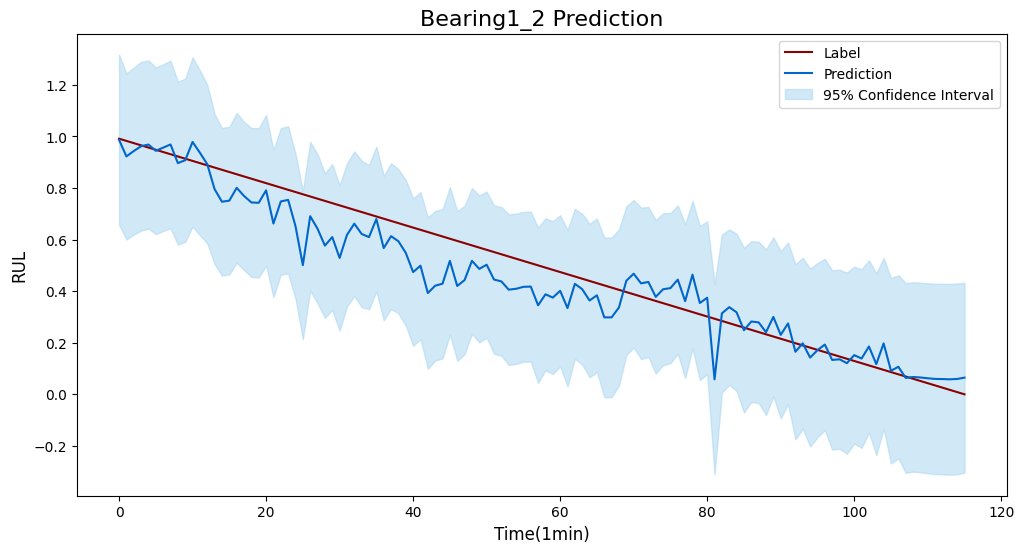

In [10]:
import matplotlib
import matplotlib.pyplot as plt

# 可视化结果
plt.figure(figsize=(12, 6), dpi=100)
plt.plot(target, label='Label',color='#8B0000')  # 真实值
plt.plot(prediction, label='Prediction',color='#0066CC')  # 预测值
# plt.plot(au, label='Aleatoric Uncertainty (log-Variance)', color='orange', linestyle='--', alpha=0.7)
# plt.plot(eu, label='Epistemic Uncertainty (Variance)', color='purple', linestyle='--', alpha=0.7)
print("EU mean", np.mean(eu))

plt.title(TEST_xj[0] +' Prediction' + 'RMSE:' + str(test_rmse), fontsize=16)
plt.fill_between(np.arange(len(target)), lower_bound, upper_bound, color='#A5D4F0', alpha=0.5, label='95% Confidence Interval')

plt.xlabel('Time(1min)', fontsize=12)
plt.ylabel('RUL', fontsize=12)
plt.title(TEST_xj[0] +' Prediction', fontsize=16)
plt.legend()
plt.savefig(f'../fbtcn_results/{TEST_xj[0]}_fbtcn.png')

# 保存数据
dump(target, '../fbtcn_results/' + TEST_xj[0] + '_fbtcn_origin') 
dump(prediction, '../fbtcn_results/' + TEST_xj[0] + '_fbtcn_pre') 
dump(au, '../fbtcn_results/' + TEST_xj[0] + '_fbtcn_au')
dump(eu, '../fbtcn_results/' + TEST_xj[0] + '_fbtcn_eu')
import pandas as pd

# 将真实值和预测值保存为csv，真实值在第一列，预测值在第二列
result_df = pd.DataFrame(np.column_stack([target, prediction, au, eu]))
result_df.to_csv(TEST_xj[0]+'_fbtcn_result.csv', index=False, header=False, encoding='utf-8')
# 把当前使用的超参数也保存下来，命名为 TEST_xj[0]+'_bilstm_result.json'

import json

# 假设你的超参数字典变量名为 config，如果不是请替换为实际使用的变量名
# 为了避免出错，可通过读取你实际用到的配置文件
with open('../../config/fbtcn_config_jupyter_bak.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

with open(TEST_xj[0]+'_tcnsa_result.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)

In [11]:
# 保存当前训练的所有指标，并与上一次训练进行对比
import json
import os
from datetime import datetime

# 定义指标名称（中文和英文）- 需要在前面定义以便后续使用
metric_names = {
    'MSE': '均方误差-MSE',
    'RMSE': '均方根误差-RMSE',
    'MAE': '平均绝对误差-MAE',
    'R2': 'R²分数',
    'PICP': 'PICP',
    'NMPIW': 'NMPIW',
    'CWC': 'CWC',
    'ECE': 'ECE',
    'Aleatoric_Uncertainty': 'Aleatoric Uncertainty',
    'Epistemic_Uncertainty': 'Epistemic Uncertainty',
    'Sharpness': 'Sharpness'
}

# 1. 收集当前训练的所有指标
current_metrics = {
    'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'test_bearing': TEST_xj[0],
    'MSE': float(test_mse),
    'RMSE': float(test_rmse),
    'MAE': float(test_mae),
    'R2': float(score),
    'PICP': float(picp(y_true, lower_bound, upper_bound)),
    'NMPIW': float(nmpiw(lower_bound, upper_bound, 1.0)),
    'CWC': float(cwc(picp(y_true, lower_bound, upper_bound), nmpiw(lower_bound, upper_bound, 1.0))),
    'ECE': float(ece(y_true, y_pred_mean, au)),
    'Aleatoric_Uncertainty': float(aleatoric_uncertainty(au)),
    'Epistemic_Uncertainty': float(epistemic_uncertainty(mu_samples.squeeze(-1))),
    'Sharpness': float(sharpness(au))
}

# 2. 保存当前指标到JSON文件
metrics_file = f'../fbtcn_results/{TEST_xj[0]}_fbtcn_metrics.json'
with open(metrics_file, 'w', encoding='utf-8') as f:
    json.dump(current_metrics, f, ensure_ascii=False, indent=4)
print(f"✓ 当前指标已保存到: {metrics_file}")

# 3. 尝试加载上一次训练的指标
previous_metrics_file = f'../fbtcn_results/{TEST_xj[0]}_fbtcn_metrics_previous.json'
previous_metrics = None

if os.path.exists(previous_metrics_file):
    with open(previous_metrics_file, 'r', encoding='utf-8') as f:
        previous_metrics = json.load(f)
    print(f"✓ 找到上一次训练的指标: {previous_metrics_file}")
else:
    print(f"⚠ 未找到上一次训练的指标文件: {previous_metrics_file}")
    print("  (这是第一次保存指标，或上一次指标文件不存在)")

# 4. 如果有上一次的指标，计算差异并显示对比
if previous_metrics is not None:
    print("\n" + "="*60)
    print("指标对比分析")
    print("="*60)
    
    # 定义哪些指标越小越好（其他指标越大越好）
    lower_is_better = ['MSE', 'RMSE', 'MAE', 'NMPIW', 'ECE', 'Aleatoric_Uncertainty', 
                       'Epistemic_Uncertainty', 'Sharpness', 'CWC']
    
    comparison_results = []
    
    print(f"\n{'指标名称':<30} | {'上一次':>12} | {'当前':>12} | {'差异':>12} | {'变化':>8}")
    print("-" * 80)
    
    for key, chinese_name in metric_names.items():
        if key in current_metrics and key in previous_metrics:
            prev_val = previous_metrics[key]
            curr_val = current_metrics[key]
            diff = curr_val - prev_val
            diff_percent = (diff / prev_val * 100) if prev_val != 0 else 0
            
            # 判断改进方向
            if key in lower_is_better:
                # 越小越好：负的差异表示改进
                if diff < 0:
                    change = "↓ 改进"
                    change_symbol = "✓"
                elif diff > 0:
                    change = "↑ 变差"
                    change_symbol = "✗"
                else:
                    change = "→ 相同"
                    change_symbol = "="
            else:
                # 越大越好：正的差异表示改进
                if diff > 0:
                    change = "↑ 改进"
                    change_symbol = "✓"
                elif diff < 0:
                    change = "↓ 变差"
                    change_symbol = "✗"
                else:
                    change = "→ 相同"
                    change_symbol = "="
            
            print(f"{chinese_name:<30} | {prev_val:>12.6f} | {curr_val:>12.6f} | {diff:>+12.6f} | {change:>8}")
            
            comparison_results.append({
                'metric': chinese_name,
                'previous': prev_val,
                'current': curr_val,
                'difference': diff,
                'difference_percent': diff_percent,
                'change': change,
                'improved': change_symbol == "✓"
            })
    
    # 5. 统计改进情况
    improved_count = sum(1 for r in comparison_results if r['improved'])
    worsened_count = sum(1 for r in comparison_results if not r['improved'] and r['difference'] != 0)
    same_count = sum(1 for r in comparison_results if r['difference'] == 0)
    
    print("\n" + "-" * 80)
    print(f"总结: {improved_count}个指标改进, {worsened_count}个指标变差, {same_count}个指标相同")
    print("="*60)
    
    # 6. 保存对比结果
    comparison_data = {
        'comparison_timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'previous_metrics': previous_metrics,
        'current_metrics': current_metrics,
        'comparison_results': comparison_results,
        'summary': {
            'improved_count': improved_count,
            'worsened_count': worsened_count,
            'same_count': same_count
        }
    }
    
    comparison_file = f'../fbtcn_results/{TEST_xj[0]}_fbtcn_metrics_comparison.json'
    with open(comparison_file, 'w', encoding='utf-8') as f:
        json.dump(comparison_data, f, ensure_ascii=False, indent=4)
    print(f"\n✓ 对比结果已保存到: {comparison_file}")
    
    # 7. 将当前指标备份为上一次指标（用于下次对比）
    with open(previous_metrics_file, 'w', encoding='utf-8') as f:
        json.dump(current_metrics, f, ensure_ascii=False, indent=4)
    print(f"✓ 当前指标已备份为上一次指标: {previous_metrics_file}")
    
else:
    # 第一次运行：将当前指标也保存为上一次指标（用于下次对比）
    with open(previous_metrics_file, 'w', encoding='utf-8') as f:
        json.dump(current_metrics, f, ensure_ascii=False, indent=4)
    print(f"\n✓ 当前指标已保存为基准指标: {previous_metrics_file}")
    print("  下次训练时将自动与本次指标进行对比")

print("\n" + "="*60)
print("当前训练指标汇总")
print("="*60)
for key, chinese_name in metric_names.items():
    if key in current_metrics:
        print(f"{chinese_name:<30}: {current_metrics[key]:.6f}")
print("="*60)


✓ 当前指标已保存到: ../fbtcn_results/Bearing1_2_fbtcn_metrics.json
⚠ 未找到上一次训练的指标文件: ../fbtcn_results/Bearing1_2_fbtcn_metrics_previous.json
  (这是第一次保存指标，或上一次指标文件不存在)

✓ 当前指标已保存为基准指标: ../fbtcn_results/Bearing1_2_fbtcn_metrics_previous.json
  下次训练时将自动与本次指标进行对比

当前训练指标汇总
均方误差-MSE                      : 0.008367
均方根误差-RMSE                    : 0.091469
平均绝对误差-MAE                    : 0.072039
R²分数                          : 0.899594
PICP                          : 1.000000
NMPIW                         : 0.617753
CWC                           : 0.617753
ECE                           : 0.112845
Aleatoric Uncertainty         : 0.018238
Epistemic Uncertainty         : 0.006793
Sharpness                     : 0.018238


In [12]:
import pandas as pd

# 将真实值和预测值保存为csv，真实值在第一列，预测值在第二列
result_df = pd.DataFrame(np.column_stack([target, prediction]))
result_df.to_csv(TEST_xj[0]+'_tcnsa_result.csv', index=False, header=False, encoding='utf-8')
# 把当前使用的超参数也保存下来，命名为 TEST_xj[0]+'_bilstm_result.json'

import json

# 假设你的超参数字典变量名为 config，如果不是请替换为实际使用的变量名
# 为了避免出错，可通过读取你实际用到的配置文件
with open('../../config/fbtcn_config.json', 'r', encoding='utf-8') as f:
    config = json.load(f)

with open(TEST_xj[0]+'_fbtcn_result.json', 'w', encoding='utf-8') as f:
    json.dump(config, f, ensure_ascii=False, indent=4)


等渗回归校准

📊 在验证集上获取预测结果...


验证集样本数: 116
验证集预测均值范围: [0.0567, 0.9892]
验证集预测标准差范围: [0.1441, 0.1976]

🔧 拟合等渗回归校准器...
✓ 校准器拟合完成

📈 对测试集进行校准...

📊 评估校准效果...
------------------------------------------------------------

指标                             |             校准前 |             校准后 |         变化
---------------------------------------------------------------------------
PICP                           |        1.000000 |        0.879310 |  -0.120690
NMPIW                          |        0.623125 |        0.278681 |  -0.344443
区间宽度标准差                        |        0.054863 |        0.000000 |  -0.054863

📊 校准后的其他指标:
------------------------------------------------------------
CWC (校准后)                      | 0.599684
CWC (校准前)                      | 0.623125
CWC 改进                         | -0.023441

💾 保存校准后的结果...
✓ 校准结果已保存到: ../fbtcn_results/Bearing1_2_fbtcn_calibrated_results.csv


/tmp/ipykernel_2621/3647132558.py:146: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  plt.plot(x, y_true, 'k-', label="True RUL", linewidth=2, color='#8B0000')
/tmp/ipykernel_2621/3647132558.py:147: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "b--" (-> color='b'). The keyword argument will take precedence.
  plt.plot(x, y_pred_mean, 'b--', label="Predicted Mean", linewidth=1.5, color='#0066CC')


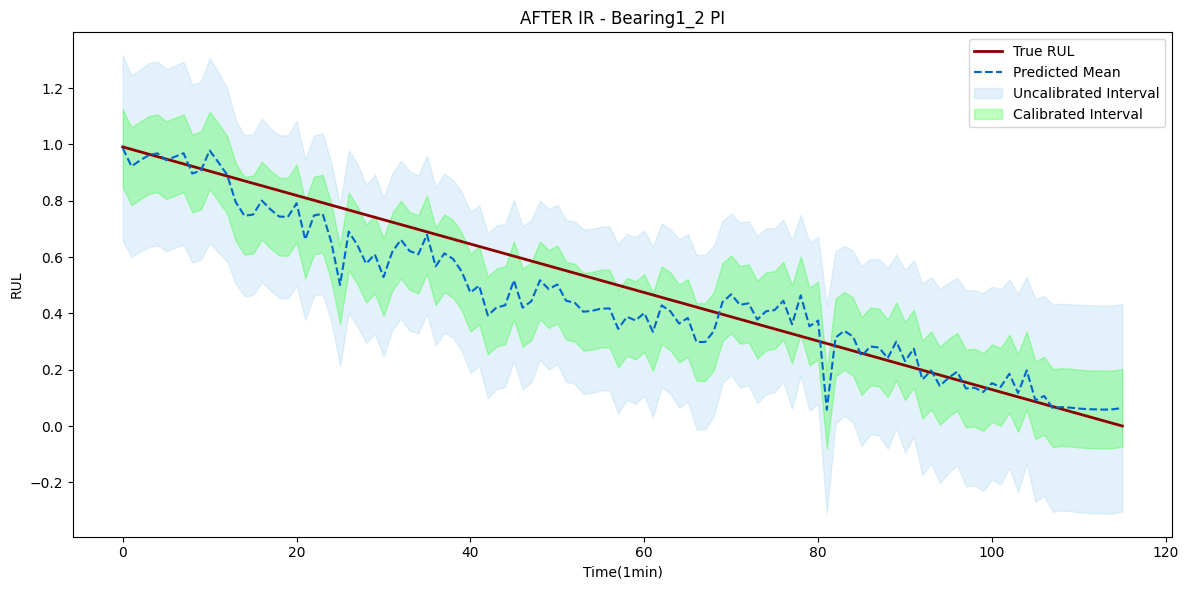


======= 校准后预测区间性能指标 =======
指标                             |            值
---------------------------------------------
PICP                           |     0.879310
NMPIW                          |     0.278681
区间宽度标准差                        |     0.000000
CWC                            |     0.599684
ECE                       | 0.125431
sharpness: 0.004968

等渗回归校准完成！
校准前的校准图


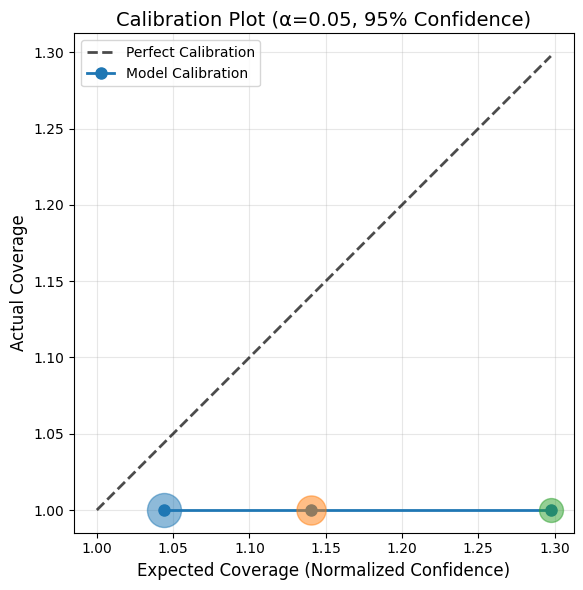

(<Figure size 800x600 with 1 Axes>,
 <Axes: title={'center': 'Calibration Plot (α=0.05, 95% Confidence)'}, xlabel='Expected Coverage (Normalized Confidence)', ylabel='Actual Coverage'>)

In [13]:
# ==================== 等渗回归校准 (Isotonic Regression Calibration) ====================
# print("校准前的校准图")
# plot_calibration(y_true, y_pred_mean, np.sqrt(au + eu))
import sys
sys.path.append('../')
from prediction_interval_calibration import IsotonicRegressionCalibrator, evaluate_calibration
from scipy import stats

print("=" * 60)
print("等渗回归校准")
print("=" * 60)
# 1. 在验证集上获取预测结果用于校准
print("\n📊 在验证集上获取预测结果...")
val_target = []
val_prediction = []
val_var_list = []
val_mu_samples_list = []

with torch.no_grad():
    for data, label in validation_loader:
        origin_label = label.tolist()
        val_target += origin_label
        model.eval()
        data, label = data.to(device), label.to(device)
        mu_list = []
        log_var = []
        with torch.no_grad():
            for _ in range(forward_pass):
                mu, sigma, kl = model(data)
                mu_list.append(mu.cpu().numpy())
                log_var.append(sigma.cpu().numpy())
        mu_samples = np.stack(mu_list, axis=0)
        sigma_samples = np.stack(log_var, axis=0)
        
        mu_mean = np.mean(mu_samples, axis=0)
        sigma_mean = np.mean(sigma_samples, axis=0)
        val_prediction += mu_mean.squeeze(-1).tolist()
        val_var_list += sigma_mean.squeeze(-1).tolist()
        val_mu_samples_list.append(mu_samples.squeeze(-1))

# 反归一化验证集预测结果
val_target = scaler.inverse_transform(np.array(val_target).reshape(-1, 1)).reshape(-1)
val_prediction = scaler.inverse_transform(np.array(val_prediction).reshape(-1, 1)).reshape(-1)
val_au = np.array(val_var_list)
val_eu = np.var(np.concatenate(val_mu_samples_list, axis=1), axis=0) if len(val_mu_samples_list) > 0 else np.zeros(len(val_target))

# 计算验证集的预测标准差（用于校准）
val_pred_std = np.sqrt(val_au + val_eu)

print(f"验证集样本数: {len(val_target)}")
print(f"验证集预测均值范围: [{val_prediction.min():.4f}, {val_prediction.max():.4f}]")
print(f"验证集预测标准差范围: [{val_pred_std.min():.4f}, {val_pred_std.max():.4f}]")

# 2. 拟合等渗回归校准器
print("\n🔧 拟合等渗回归校准器...")
alpha = 1 - ci  # 从配置中获取置信水平
calibrator = IsotonicRegressionCalibrator(alpha=alpha)
calibrator.fit(
    y_true=val_target,
    y_pred_mean=val_prediction,
    y_pred_std=val_pred_std
)
print("✓ 校准器拟合完成")

# 3. 对测试集进行校准
print("\n📈 对测试集进行校准...")
test_pred_std = np.sqrt(au + eu)  # 测试集的预测标准差
y_lower_calibrated, y_upper_calibrated = calibrator.calibrate(
    y_pred_mean=y_pred_mean,
    y_pred_std=test_pred_std
)

# 根据校准区间反推出校准后的不确定性（与样例CSV保持一致）
alpha_cal = 1 - ci
z_score = stats.norm.ppf(1 - alpha_cal / 2)
calibrated_uncertainty = (y_upper_calibrated - y_lower_calibrated) / (2 * z_score)
calibrated_variance = calibrated_uncertainty ** 2

# 4. 评估校准前后的效果
print("\n📊 评估校准效果...")
print("-" * 60)

# 校准前的指标
metrics_before = evaluate_calibration(
    y_true=y_true,
    y_lower=lower_bound,
    y_upper=upper_bound,
    confidence_level=ci
)

# 校准后的指标
metrics_after = evaluate_calibration(
    y_true=y_true,
    y_lower=y_lower_calibrated,
    y_upper=y_upper_calibrated,
    confidence_level=ci
)

print(f"\n{'指标':<30} | {'校准前':>15} | {'校准后':>15} | {'变化':>10}")
print("-" * 75)
print(f"{'PICP':<30} | {metrics_before['PICP']:>15.6f} | {metrics_after['PICP']:>15.6f} | {metrics_after['PICP'] - metrics_before['PICP']:>+10.6f}")
# print(f"{'覆盖误差 (Coverage Error)':<30} | {metrics_before['Coverage_Error']:>15.6f} | {metrics_after['Coverage_Error']:>15.6f} | {metrics_after['Coverage_Error'] - metrics_before['Coverage_Error']:>+10.6f}")
print(f"{'NMPIW':<30} | {metrics_before['NMPIW']:>15.6f} | {metrics_after['NMPIW']:>15.6f} | {metrics_after['NMPIW'] - metrics_before['NMPIW']:>+10.6f}")
# print(f"{'MPIW':<30} | {metrics_before['MPIW']:>15.6f} | {metrics_after['MPIW']:>15.6f} | {metrics_after['MPIW'] - metrics_before['MPIW']:>+10.6f}")
print(f"{'区间宽度标准差':<30} | {metrics_before['Interval_Width_Std']:>15.6f} | {metrics_after['Interval_Width_Std']:>15.6f} | {metrics_after['Interval_Width_Std'] - metrics_before['Interval_Width_Std']:>+10.6f}")

# 5. 计算校准后的其他指标
print("\n📊 校准后的其他指标:")
print("-" * 60)
cwc_calibrated = cwc(metrics_after['PICP'], metrics_after['NMPIW'])
print(f"{'CWC (校准后)':<30} | {cwc_calibrated:.6f}")
print(f"{'CWC (校准前)':<30} | {cwc(metrics_before['PICP'], metrics_before['NMPIW']):.6f}")
print(f"{'CWC 改进':<30} | {cwc_calibrated - cwc(metrics_before['PICP'], metrics_before['NMPIW']):+.6f}")

# 6. 保存校准后的结果
print("\n💾 保存校准后的结果...")
calibrated_pred_df = pd.DataFrame({
    'y_true': y_true,
    'y_pred_mean': y_pred_mean,
    'y_lower_calibrated': y_lower_calibrated,
    'y_upper_calibrated': y_upper_calibrated,
    'y_pred_std_total': test_pred_std,
    'y_pred_std_calibrated': calibrated_uncertainty,
    'y_pred_alea': au,
    'y_pred_epi': eu
})
calibrated_pred_df.to_csv(
    f'../fbtcn_results/{TEST_xj[0]}_fbtcn_calibrated_results.csv',
    index=False,
    encoding='utf-8-sig'
)
print(f"✓ 校准结果已保存到: ../fbtcn_results/{TEST_xj[0]}_fbtcn_calibrated_results.csv")

# 更新变量以便后续使用
lower_bound_calibrated = y_lower_calibrated
upper_bound_calibrated = y_upper_calibrated

# 绘制校准后的预测区间图，并重新计算各项指标

import matplotlib.pyplot as plt
import numpy as np

# 1. 绘制校准后的置信区间图
plt.figure(figsize=(12, 6))
x = np.arange(len(y_true))
plt.plot(x, y_true, 'k-', label="True RUL", linewidth=2, color='#8B0000')
plt.plot(x, y_pred_mean, 'b--', label="Predicted Mean", linewidth=1.5, color='#0066CC')
plt.fill_between(x, lower_bound, upper_bound, color='#A5D4F0', alpha=0.3, label='Uncalibrated Interval')
plt.fill_between(x, y_lower_calibrated, y_upper_calibrated, color='lime', alpha=0.25, label='Calibrated Interval')
plt.legend(loc='best')
plt.title(f"AFTER IR - {TEST_xj[0]} PI")
plt.xlabel("Time(1min)")
plt.ylabel("RUL")
plt.tight_layout()
plt.show()

# 2. 重新计算和输出校准后的指标
print("\n======= 校准后预测区间性能指标 =======")
metrics_after_recompute = evaluate_calibration(
    y_true=y_true,
    y_lower=y_lower_calibrated,
    y_upper=y_upper_calibrated,
    confidence_level=ci
)
print(f"{'指标':<30} | {'值':>12}")
print("-" * 45)
print(f"{'PICP':<30} | {metrics_after_recompute['PICP']:>12.6f}")
# print(f"{'覆盖误差 (Coverage Error)':<30} | {metrics_after_recompute['Coverage_Error']:>12.6f}")
print(f"{'NMPIW':<30} | {metrics_after_recompute['NMPIW']:>12.6f}")
# print(f"{'MPIW':<30} | {metrics_after_recompute['MPIW']:>12.6f}")
print(f"{'区间宽度标准差':<30} | {metrics_after_recompute['Interval_Width_Std']:>12.6f}")
print(f"{'CWC':<30} | {cwc(metrics_after_recompute['PICP'], metrics_after_recompute['NMPIW']):>12.6f}")
# 使用校准后的不确定性计算ECE（反映校准后的不确定性质量）
print(f"{'ECE':<25} | {ece(y_true, y_pred_mean, calibrated_variance):.6f}")
print(f"sharpness: {sharpness(calibrated_variance):.6f}")

print("\n" + "=" * 60)
print("等渗回归校准完成！")
print("=" * 60)

print("校准前的校准图")
plot_calibration(y_true, y_pred_mean, np.sqrt(au + eu))